In [1]:
import copy
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from bax.models.simple_gp import SimpleGp
from bax.alg.algorithms import Dijkstras
from bax.acq.acqoptimize import AcqOptimizer

from typing import List
from bax.util.graph import Vertex, make_vertices, make_edges, farthest_pair, edges_of_path, positions_of_path

import neatplot
neatplot.set_style('fonts')

In [2]:
# Set random seed
seed = 0
np.random.seed(seed)

In [3]:
# make a grid

g = 10
x1, x2 = np.meshgrid(np.linspace(-1, 1, g), np.linspace(-1, 1, g))
positions = np.stack([x1.flatten(), x2.flatten()], axis=-1)
n = len(positions)

has_edge = [[False for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(i + 1, n):
        if ((abs(i - j) == 1) and (j % g != 0)):
            has_edge[i][j] = True
        elif (abs(i - j) == g):
            has_edge[i][j] = True
        else:
            has_edge[i][j] = False
has_edge = np.array(has_edge)

In [4]:
has_edge

array([[False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [5]:
vertices = make_vertices(positions, has_edge)

In [6]:
vertices[0]

(0, [1, 10])

In [7]:
edges = make_edges(vertices)

In [8]:
# make a graph
def l2_dist(u: Vertex, v: Vertex):
    return np.sqrt(np.sum((u.position - v.position)**2))

start, goal = farthest_pair(vertices, distance_func=l2_dist)

In [9]:
def cost_func(u: Vertex, v: Vertex):
    # TODO: make this an input to Dijstra Algorithm
    u_pos, v_pos = u.position, v.position
    fu, fv = f(u_pos), f(v_pos)
    return abs(fu - fv)

def cost_of_path(path, cost_func):
    cost = 0
    for i in range(len(path) - 1):
        cost += cost_func(path[i], path[i+1])
    return cost

In [10]:
# Set function
f = lambda x: x[0]**2 + x[1]**2

# Set data for model
data = Namespace()
data.x = []
data.y = [f(x) for x in data.x]

# Set model as a GP
gp_params = {'ls': 1.0, 'alpha': 1.0, 'sigma': 1e-2}
model = SimpleGp(gp_params)
model.set_data(data)

# Set algorithm
algo = Dijkstras({
    'start': start,
    'goal': goal,
    'vertices': vertices})

#x_test = positions # input points to maximize acquisition function over

*[INFO] SimpleGp with params=Namespace(alpha=1.0, kernel=<function kern_exp_quad at 0x7f7a47346430>, ls=1.0, name='SimpleGp', sigma=0.01)
*[INFO] Dijkstras with params=Namespace(goal=(99, [89, 98]), name='Dijkstras', start=(0, [1, 10]), vertices=[(0, [1, 10]), (1, [0, 2, 11]), (2, [1, 3, 12]), (3, [2, 4, 13]), (4, [3, 5, 14]), (5, [4, 6, 15]), (6, [5, 7, 16]), (7, [6, 8, 17]), (8, [7, 9, 18]), (9, [8, 19]), (10, [0, 11, 20]), (11, [1, 10, 12, 21]), (12, [2, 11, 13, 22]), (13, [3, 12, 14, 23]), (14, [4, 13, 15, 24]), (15, [5, 14, 16, 25]), (16, [6, 15, 17, 26]), (17, [7, 16, 18, 27]), (18, [8, 17, 19, 28]), (19, [9, 18, 29]), (20, [10, 21, 30]), (21, [11, 20, 22, 31]), (22, [12, 21, 23, 32]), (23, [13, 22, 24, 33]), (24, [14, 23, 25, 34]), (25, [15, 24, 26, 35]), (26, [16, 25, 27, 36]), (27, [17, 26, 28, 37]), (28, [18, 27, 29, 38]), (29, [19, 28, 39]), (30, [20, 31, 40]), (31, [21, 30, 32, 41]), (32, [22, 31, 33, 42]), (33, [23, 32, 34, 43]), (34, [24, 33, 35, 44]), (35, [25, 34, 36, 4

In [11]:
from matplotlib.collections import LineCollection as LC


def plot_path(ax, path, path_color=(0, 0, 0, 1.), linewidths=2, linestyle="dotted", plot_vertices=False):
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(path_lines, colors=[path_color] * len(path_lines), linewidths=linewidths, linestyle=linestyle)
    ax.add_collection(path_lc)
    
    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

def plot_graph(ax, edges, start: Vertex, goal: Vertex):
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), facecolors='none')

    # plot start and goal vertices
    ax.scatter(*start.position, color='g', label="start", s=100)
    ax.scatter(*goal.position, color='r', label="goal", s=100)
    
    ax.grid(False)
    ax.legend()
    return

def plot_progress(edges, start: Vertex, goal: Vertex, path: List[Vertex]):
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_graph(ax, edges, start, goal)
    plot_path(ax, path)
    return fig, ax

In [12]:
def possible_steps(vertex: Vertex):
    neighbors = vertex.neighbors
    possible_positions = np.stack([n.position for n in neighbors])
    return possible_positions

current_path = [start]
x_test = possible_steps(start)
#x_test = positions

*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 64 vertices with estimated cost 0.5226387645703079
Found goal after visiting 100 vertices with estimated cost 2.5519814963102476
Found goal after visiting 83 vertices with estimated cost 1.414935964056353
Found goal after visiting 99 vertices with estimated cost 3.3957800282375508
Found goal after visiting 100 vertices with estimated cost 2.020060855262882
Found goal after visiting 96 vertices with estimated cost 1.0244500579125153
Found goal after visiting 96 vertices with estimated cost 2.9536242510434665
Found goal after visiting 99 vertices with estimated cost 1.0612146195475094
Found goal after visiting 91 vertices with estimated cost 2.330250325068336
Found goal after visiting 95 vertices with estimated cost 1.350592641683508
*[TIME] [Sample 10 execution paths] Elapsed: 25.94 seconds
*[TIME] [Pre-compute acquisition funct

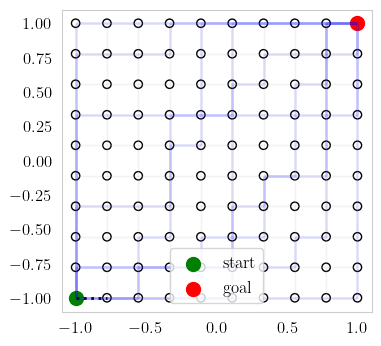

Acq optimizer x_next = (1, [0, 2, 11])
Finished iter i = 0
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 93 vertices with estimated cost 2.656603347353446
Found goal after visiting 100 vertices with estimated cost 1.7912895139085578
Found goal after visiting 85 vertices with estimated cost 2.7535916162562755
Found goal after visiting 89 vertices with estimated cost 3.8961190665361265
Found goal after visiting 91 vertices with estimated cost 2.8370538545553847
Found goal after visiting 93 vertices with estimated cost 1.260691926724912
Found goal after visiting 61 vertices with estimated cost 1.3115426981289708
Found goal after visiting 93 vertices with estimated cost 3.217052404224746
Found goal after visiting 97 vertices with estimated cost 1.537426221398569
Found goal after visiting 65 vertices with estimated cost 1.0296613498773486
*[TIME] [Sample 10 execution paths] Ela

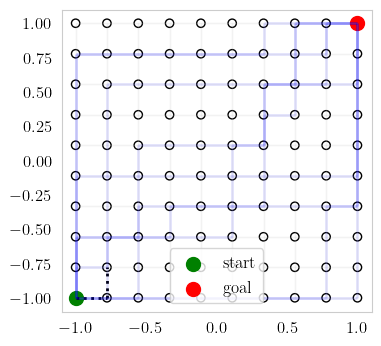

Acq optimizer x_next = (11, [1, 10, 12, 21])
Finished iter i = 1
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 90 vertices with estimated cost 1.7107195000328324
Found goal after visiting 68 vertices with estimated cost 2.5583191054341485
Found goal after visiting 100 vertices with estimated cost 3.7437429984636936
Found goal after visiting 88 vertices with estimated cost 1.9831165749443775
Found goal after visiting 100 vertices with estimated cost 2.7379542762242703
Found goal after visiting 97 vertices with estimated cost 4.02218800942392
Found goal after visiting 100 vertices with estimated cost 2.7308118804372903
Found goal after visiting 99 vertices with estimated cost 2.4022707225699866
Found goal after visiting 91 vertices with estimated cost 1.8211066550117205
Found goal after visiting 100 vertices with estimated cost 2.6546524884296026
*[TIME] [Sample 10 execution

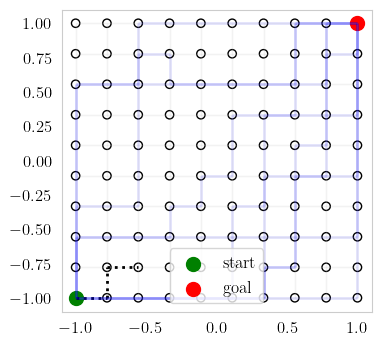

Acq optimizer x_next = (12, [2, 11, 13, 22])
Finished iter i = 2
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 99 vertices with estimated cost 4.42874835626588
Found goal after visiting 70 vertices with estimated cost 2.406497431643392
Found goal after visiting 68 vertices with estimated cost 2.754555099424142
Found goal after visiting 100 vertices with estimated cost 2.3635557096467497
Found goal after visiting 87 vertices with estimated cost 2.9372428466974396
Found goal after visiting 98 vertices with estimated cost 3.00097757096443
Found goal after visiting 71 vertices with estimated cost 3.409910729651495
Found goal after visiting 53 vertices with estimated cost 2.505323158515167
Found goal after visiting 73 vertices with estimated cost 2.786563480059343
Found goal after visiting 100 vertices with estimated cost 2.4837799071658617
*[TIME] [Sample 10 execution paths] E

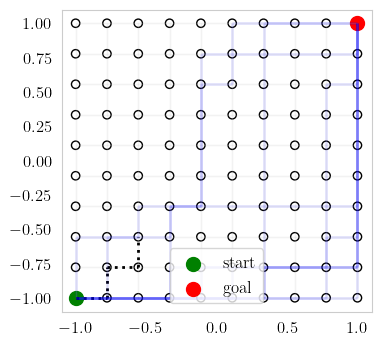

Acq optimizer x_next = (22, [12, 21, 23, 32])
Finished iter i = 3
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.199316595864226
Found goal after visiting 100 vertices with estimated cost 3.235369229524788
Found goal after visiting 85 vertices with estimated cost 2.581428693045285
Found goal after visiting 80 vertices with estimated cost 2.433508000508318
Found goal after visiting 88 vertices with estimated cost 2.4890172032539897
Found goal after visiting 98 vertices with estimated cost 3.0262973378873634
Found goal after visiting 61 vertices with estimated cost 1.5361036074713241
Found goal after visiting 81 vertices with estimated cost 2.1721222472308894
Found goal after visiting 77 vertices with estimated cost 2.4312310063889795
Found goal after visiting 98 vertices with estimated cost 2.5265618523032165
*[TIME] [Sample 10 execution pa

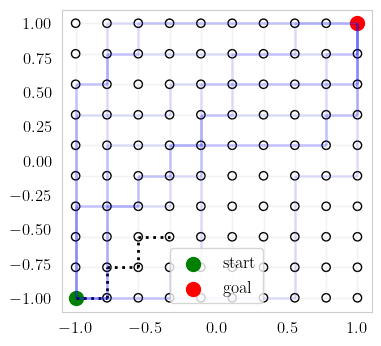

Acq optimizer x_next = (23, [13, 22, 24, 33])
Finished iter i = 4
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 99 vertices with estimated cost 2.1888634844527157
Found goal after visiting 98 vertices with estimated cost 3.6669025323529447
Found goal after visiting 93 vertices with estimated cost 2.6429250782851246
Found goal after visiting 100 vertices with estimated cost 2.3420113226014183
Found goal after visiting 99 vertices with estimated cost 2.2246266159475523
Found goal after visiting 80 vertices with estimated cost 2.0853783166453113
Found goal after visiting 99 vertices with estimated cost 2.3383145144295785
Found goal after visiting 100 vertices with estimated cost 1.9234926092929194
Found goal after visiting 70 vertices with estimated cost 2.023021492150025
Found goal after visiting 100 vertices with estimated cost 2.4339879397300335
*[TIME] [Sample 10 executio

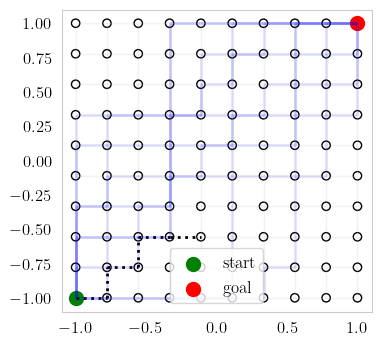

Acq optimizer x_next = (24, [14, 23, 25, 34])
Finished iter i = 5
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 80 vertices with estimated cost 1.861892615434566
Found goal after visiting 99 vertices with estimated cost 2.1777188721025986
Found goal after visiting 100 vertices with estimated cost 2.0456348872307695
Found goal after visiting 87 vertices with estimated cost 1.878373020993804
Found goal after visiting 100 vertices with estimated cost 2.146602347559809
Found goal after visiting 100 vertices with estimated cost 2.228509523558072
Found goal after visiting 84 vertices with estimated cost 1.7626783956216525
Found goal after visiting 100 vertices with estimated cost 2.8242261606798778
Found goal after visiting 100 vertices with estimated cost 2.157592026091839
Found goal after visiting 100 vertices with estimated cost 1.8898891429478337
*[TIME] [Sample 10 execution

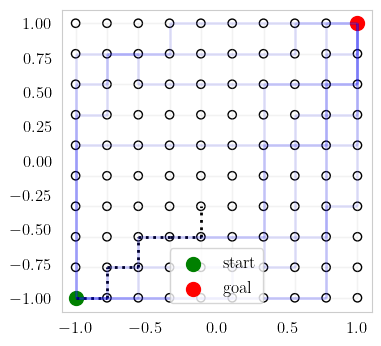

Acq optimizer x_next = (34, [24, 33, 35, 44])
Finished iter i = 6
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 98 vertices with estimated cost 2.842960459241819
Found goal after visiting 78 vertices with estimated cost 1.9042075554382345
Found goal after visiting 81 vertices with estimated cost 1.9571644703800073
Found goal after visiting 100 vertices with estimated cost 3.0815161314330775
Found goal after visiting 97 vertices with estimated cost 2.319727577090144
Found goal after visiting 87 vertices with estimated cost 2.4427244461634956
Found goal after visiting 100 vertices with estimated cost 2.3670861003841783
Found goal after visiting 95 vertices with estimated cost 2.025303553010903
Found goal after visiting 100 vertices with estimated cost 2.5892934561479533
Found goal after visiting 68 vertices with estimated cost 1.8853269521365432
*[TIME] [Sample 10 execution 

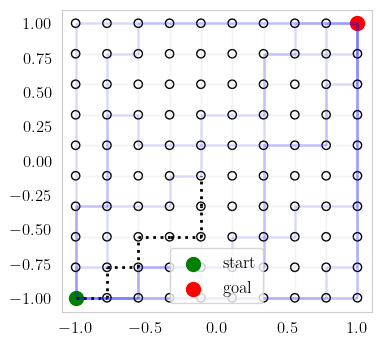

Acq optimizer x_next = (44, [34, 43, 45, 54])
Finished iter i = 7
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.7774158248617926
Found goal after visiting 83 vertices with estimated cost 1.9500018922755664
Found goal after visiting 100 vertices with estimated cost 2.416150800914907
Found goal after visiting 96 vertices with estimated cost 2.510467226805964
Found goal after visiting 99 vertices with estimated cost 2.684681882224715
Found goal after visiting 99 vertices with estimated cost 2.131748057019139
Found goal after visiting 96 vertices with estimated cost 2.389898198341868
Found goal after visiting 86 vertices with estimated cost 2.2936520430215612
Found goal after visiting 100 vertices with estimated cost 2.4299172860804457
Found goal after visiting 78 vertices with estimated cost 2.171860393685742
*[TIME] [Sample 10 execution pat

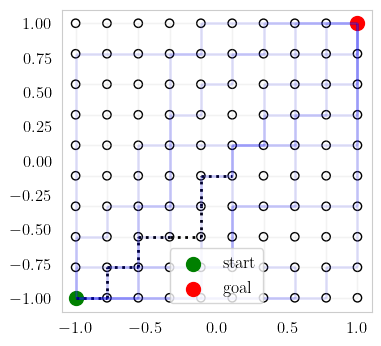

Acq optimizer x_next = (45, [35, 44, 46, 55])
Finished iter i = 8
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 94 vertices with estimated cost 2.306770996487328
Found goal after visiting 100 vertices with estimated cost 2.890548403579938
Found goal after visiting 100 vertices with estimated cost 2.3188904079883605
Found goal after visiting 75 vertices with estimated cost 1.7911843028312755
Found goal after visiting 100 vertices with estimated cost 2.988658330206926
Found goal after visiting 89 vertices with estimated cost 2.371960636827385
Found goal after visiting 95 vertices with estimated cost 2.21698836881901
Found goal after visiting 96 vertices with estimated cost 2.1875112742788216
Found goal after visiting 75 vertices with estimated cost 1.6690096506825758
Found goal after visiting 100 vertices with estimated cost 2.458273835183895
*[TIME] [Sample 10 execution pat

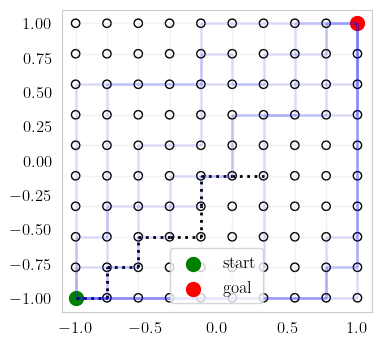

Acq optimizer x_next = (46, [36, 45, 47, 56])
Finished iter i = 9
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 2.1938934015694356
Found goal after visiting 64 vertices with estimated cost 1.6040744701091598
Found goal after visiting 97 vertices with estimated cost 2.0052778682616377
Found goal after visiting 100 vertices with estimated cost 2.896380235109423
Found goal after visiting 100 vertices with estimated cost 2.7199152536696687
Found goal after visiting 99 vertices with estimated cost 2.1352157090175234
Found goal after visiting 100 vertices with estimated cost 2.241885373398371
Found goal after visiting 99 vertices with estimated cost 2.3402942299089258
Found goal after visiting 73 vertices with estimated cost 1.9185646441000723
Found goal after visiting 87 vertices with estimated cost 1.9878634190684996
*[TIME] [Sample 10 execution

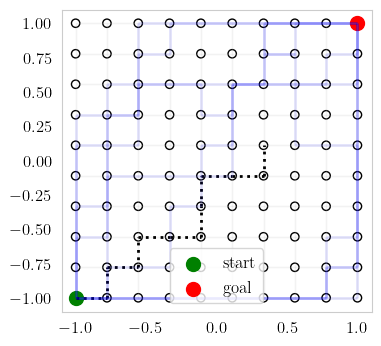

Acq optimizer x_next = (56, [46, 55, 57, 66])
Finished iter i = 10
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 56 vertices with estimated cost 1.6004777631370066
Found goal after visiting 100 vertices with estimated cost 2.4822251816415934
Found goal after visiting 100 vertices with estimated cost 2.9712876789931557
Found goal after visiting 100 vertices with estimated cost 2.606110240811802
Found goal after visiting 100 vertices with estimated cost 2.2374320611984393
Found goal after visiting 100 vertices with estimated cost 2.371415859275455
Found goal after visiting 92 vertices with estimated cost 1.9182153422058752
Found goal after visiting 100 vertices with estimated cost 2.556410021660369
Found goal after visiting 89 vertices with estimated cost 1.8666121198106194
Found goal after visiting 40 vertices with estimated cost 1.36275872204634
*[TIME] [Sample 10 executio

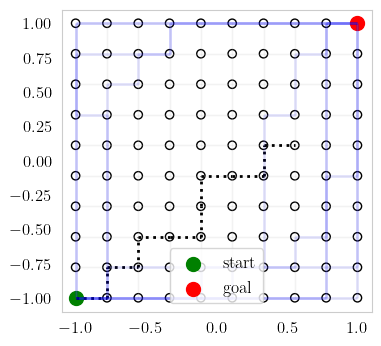

Acq optimizer x_next = (57, [47, 56, 58, 67])
Finished iter i = 11
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 68 vertices with estimated cost 1.6892931468758892
Found goal after visiting 100 vertices with estimated cost 2.047980447111026
Found goal after visiting 100 vertices with estimated cost 2.278588211903584
Found goal after visiting 100 vertices with estimated cost 2.1280402036840473
Found goal after visiting 85 vertices with estimated cost 1.9639208457715691
Found goal after visiting 100 vertices with estimated cost 2.1584268820011956
Found goal after visiting 95 vertices with estimated cost 2.4145797696410147
Found goal after visiting 100 vertices with estimated cost 1.8746765605911873
Found goal after visiting 83 vertices with estimated cost 1.9300398580467504
Found goal after visiting 98 vertices with estimated cost 2.376033021460158
*[TIME] [Sample 10 executi

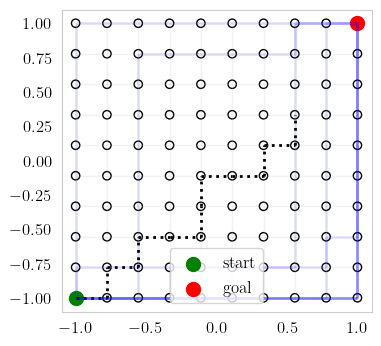

Acq optimizer x_next = (67, [57, 66, 68, 77])
Finished iter i = 12
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.5369114617758344
Found goal after visiting 96 vertices with estimated cost 2.5177225317757923
Found goal after visiting 100 vertices with estimated cost 2.608490878751336
Found goal after visiting 100 vertices with estimated cost 2.7651739425075963
Found goal after visiting 94 vertices with estimated cost 2.078464147713797
Found goal after visiting 100 vertices with estimated cost 2.743150785123771
Found goal after visiting 100 vertices with estimated cost 2.545875399526107
Found goal after visiting 99 vertices with estimated cost 2.250709924231841
Found goal after visiting 98 vertices with estimated cost 2.783173161671762
Found goal after visiting 81 vertices with estimated cost 1.7851072113680873
*[TIME] [Sample 10 execution 

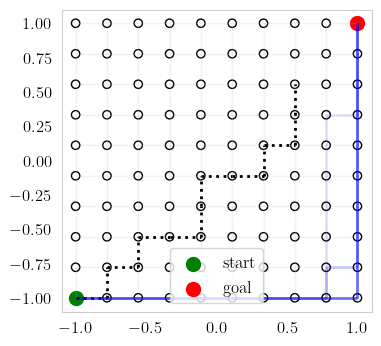

Acq optimizer x_next = (77, [67, 76, 78, 87])
Finished iter i = 13
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 99 vertices with estimated cost 2.2423856988524653
Found goal after visiting 100 vertices with estimated cost 2.473130415760197
Found goal after visiting 91 vertices with estimated cost 2.212778410962795
Found goal after visiting 100 vertices with estimated cost 2.8610913989169733
Found goal after visiting 90 vertices with estimated cost 2.1257975313088515
Found goal after visiting 95 vertices with estimated cost 2.2184724640720073
Found goal after visiting 95 vertices with estimated cost 2.4803178636962553
Found goal after visiting 91 vertices with estimated cost 2.412167436164819
Found goal after visiting 77 vertices with estimated cost 1.7090247580860363
Found goal after visiting 100 vertices with estimated cost 2.535242628244405
*[TIME] [Sample 10 execution 

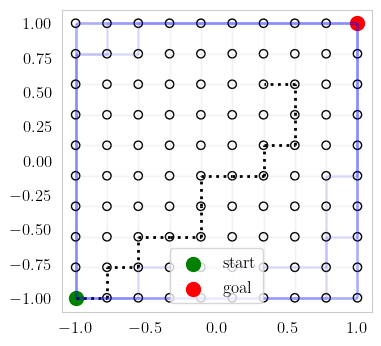

Acq optimizer x_next = (76, [66, 75, 77, 86])
Finished iter i = 14
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 85 vertices with estimated cost 2.1116192999729684
Found goal after visiting 98 vertices with estimated cost 2.1165860346000223
Found goal after visiting 100 vertices with estimated cost 2.999241411563543
Found goal after visiting 95 vertices with estimated cost 2.3587573363455396
Found goal after visiting 100 vertices with estimated cost 2.321601679022354
Found goal after visiting 96 vertices with estimated cost 2.0233518414778437
Found goal after visiting 94 vertices with estimated cost 2.3760372641871568
Found goal after visiting 100 vertices with estimated cost 2.410379023209749
Found goal after visiting 100 vertices with estimated cost 2.924812422754875
Found goal after visiting 99 vertices with estimated cost 2.324013938142361
*[TIME] [Sample 10 execution 

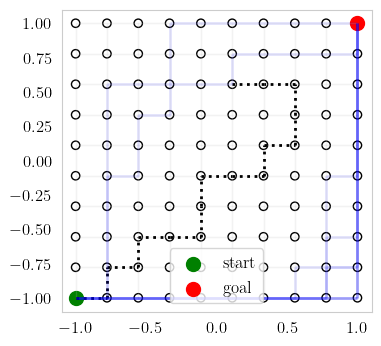

Acq optimizer x_next = (75, [65, 74, 76, 85])
Finished iter i = 15
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 91 vertices with estimated cost 1.9874705365594298
Found goal after visiting 100 vertices with estimated cost 2.536578092666314
Found goal after visiting 99 vertices with estimated cost 2.7180401407696273
Found goal after visiting 56 vertices with estimated cost 1.6851540768314295
Found goal after visiting 100 vertices with estimated cost 2.417693233061777
Found goal after visiting 96 vertices with estimated cost 2.067481622834018
Found goal after visiting 98 vertices with estimated cost 2.2264100241969613
Found goal after visiting 82 vertices with estimated cost 1.757308538989995
Found goal after visiting 100 vertices with estimated cost 2.577131285708483
Found goal after visiting 100 vertices with estimated cost 2.3808795405762035
*[TIME] [Sample 10 execution 

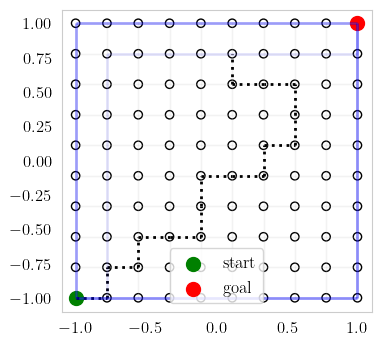

Acq optimizer x_next = (85, [75, 84, 86, 95])
Finished iter i = 16
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 85 vertices with estimated cost 1.9932700499633313
Found goal after visiting 90 vertices with estimated cost 2.383868965643255
Found goal after visiting 82 vertices with estimated cost 2.1623669953606317
Found goal after visiting 97 vertices with estimated cost 2.1434914102456664
Found goal after visiting 85 vertices with estimated cost 2.1568749049778004
Found goal after visiting 100 vertices with estimated cost 2.685633401868867
Found goal after visiting 100 vertices with estimated cost 2.0867093535459436
Found goal after visiting 96 vertices with estimated cost 2.5615696673973867
Found goal after visiting 98 vertices with estimated cost 2.4202769393649124
Found goal after visiting 99 vertices with estimated cost 2.062969585424253
*[TIME] [Sample 10 execution 

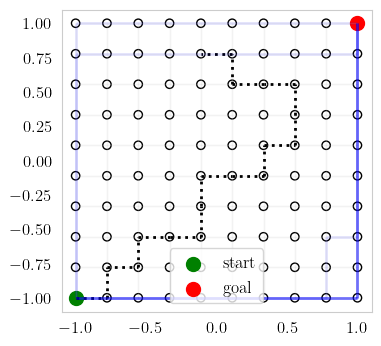

Acq optimizer x_next = (84, [74, 83, 85, 94])
Finished iter i = 17
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 89 vertices with estimated cost 1.9599426254475663
Found goal after visiting 99 vertices with estimated cost 2.286838056223437
Found goal after visiting 100 vertices with estimated cost 2.41592217002833
Found goal after visiting 82 vertices with estimated cost 1.9587806142570336
Found goal after visiting 88 vertices with estimated cost 2.404327677859392
Found goal after visiting 99 vertices with estimated cost 2.4273586831191647
Found goal after visiting 100 vertices with estimated cost 2.3019060643438953
Found goal after visiting 82 vertices with estimated cost 2.1115625109669067
Found goal after visiting 100 vertices with estimated cost 2.4205061329736983
Found goal after visiting 100 vertices with estimated cost 3.0747035453798226
*[TIME] [Sample 10 execution

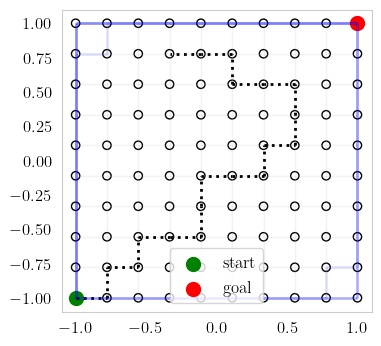

Acq optimizer x_next = (83, [73, 82, 84, 93])
Finished iter i = 18
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 97 vertices with estimated cost 2.1857154928598828
Found goal after visiting 99 vertices with estimated cost 2.500557107614556
Found goal after visiting 100 vertices with estimated cost 2.636906250858181
Found goal after visiting 89 vertices with estimated cost 2.32705446353823
Found goal after visiting 100 vertices with estimated cost 2.4945715865904248
Found goal after visiting 92 vertices with estimated cost 1.9921086557957877
Found goal after visiting 99 vertices with estimated cost 2.311551903126931
Found goal after visiting 78 vertices with estimated cost 1.7203660225526185
Found goal after visiting 64 vertices with estimated cost 1.7300248644864271
Found goal after visiting 100 vertices with estimated cost 2.5139529238978797
*[TIME] [Sample 10 execution p

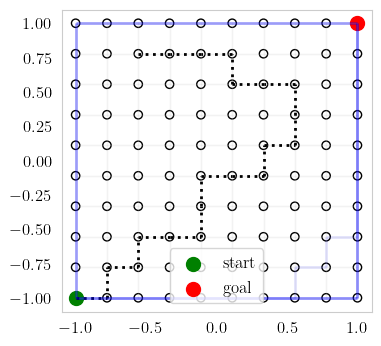

Acq optimizer x_next = (82, [72, 81, 83, 92])
Finished iter i = 19
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 99 vertices with estimated cost 2.539987783295174
Found goal after visiting 92 vertices with estimated cost 2.0027550983618987
Found goal after visiting 97 vertices with estimated cost 2.6511118953298816
Found goal after visiting 98 vertices with estimated cost 2.278713115912116
Found goal after visiting 85 vertices with estimated cost 2.00217824946074
Found goal after visiting 97 vertices with estimated cost 2.7221979366772397
Found goal after visiting 78 vertices with estimated cost 1.902648927398132
Found goal after visiting 98 vertices with estimated cost 2.2619030457718945
Found goal after visiting 97 vertices with estimated cost 2.6388127516306916
Found goal after visiting 100 vertices with estimated cost 2.8156958939958177
*[TIME] [Sample 10 execution pat

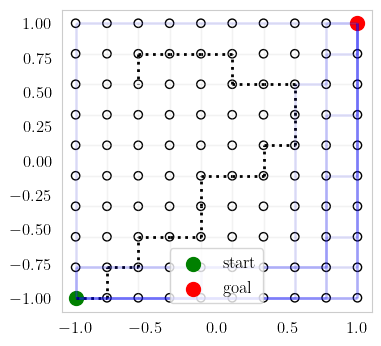

Acq optimizer x_next = (72, [62, 71, 73, 82])
Finished iter i = 20
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 98 vertices with estimated cost 2.846223850730163
Found goal after visiting 92 vertices with estimated cost 2.527076930264559
Found goal after visiting 83 vertices with estimated cost 2.155660118669945
Found goal after visiting 94 vertices with estimated cost 2.350048545518564
Found goal after visiting 98 vertices with estimated cost 2.7850742059769398
Found goal after visiting 100 vertices with estimated cost 2.9176017101560054
Found goal after visiting 90 vertices with estimated cost 2.361307211626208
Found goal after visiting 82 vertices with estimated cost 2.119547567550196
Found goal after visiting 82 vertices with estimated cost 2.0559802051902945
Found goal after visiting 97 vertices with estimated cost 2.153443216653887
*[TIME] [Sample 10 execution paths

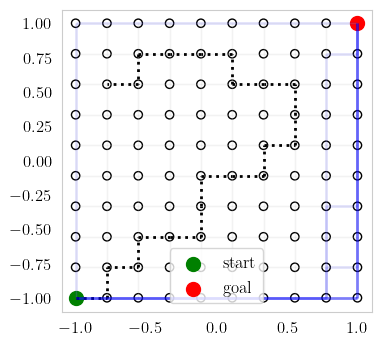

Acq optimizer x_next = (71, [61, 70, 72, 81])
Finished iter i = 21
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 89 vertices with estimated cost 2.39897486193746
Found goal after visiting 100 vertices with estimated cost 2.696596327435083
Found goal after visiting 88 vertices with estimated cost 2.217094637926933
Found goal after visiting 82 vertices with estimated cost 2.1566990767360696
Found goal after visiting 83 vertices with estimated cost 2.1633149222548007
Found goal after visiting 94 vertices with estimated cost 2.5163109528517866
Found goal after visiting 91 vertices with estimated cost 2.428660557441919
Found goal after visiting 99 vertices with estimated cost 2.388135509980576
Found goal after visiting 100 vertices with estimated cost 2.799757444000141
Found goal after visiting 98 vertices with estimated cost 2.5155886861416605
*[TIME] [Sample 10 execution path

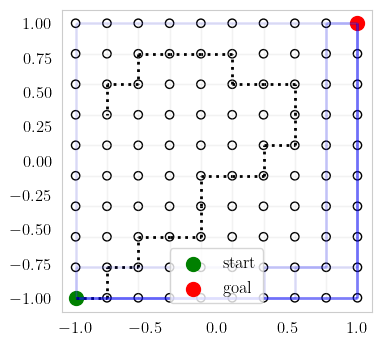

Acq optimizer x_next = (61, [51, 60, 62, 71])
Finished iter i = 22
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 82 vertices with estimated cost 1.9240165259711857
Found goal after visiting 94 vertices with estimated cost 2.4696552412251176
Found goal after visiting 98 vertices with estimated cost 2.3720150981658765
Found goal after visiting 96 vertices with estimated cost 2.395166365001784
Found goal after visiting 85 vertices with estimated cost 2.040326541447247
Found goal after visiting 100 vertices with estimated cost 2.5607113073066587
Found goal after visiting 83 vertices with estimated cost 2.0570297785108456
Found goal after visiting 100 vertices with estimated cost 2.7069069367727456
Found goal after visiting 94 vertices with estimated cost 2.377925213413307
Found goal after visiting 100 vertices with estimated cost 2.4798640114850867
*[TIME] [Sample 10 execution

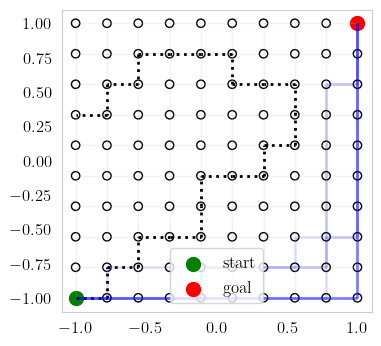

Acq optimizer x_next = (60, [50, 61, 70])
Finished iter i = 23
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 91 vertices with estimated cost 2.3755816400659513
Found goal after visiting 96 vertices with estimated cost 2.4455132406457785
Found goal after visiting 91 vertices with estimated cost 2.211482250907185
Found goal after visiting 100 vertices with estimated cost 2.780745435052091
Found goal after visiting 100 vertices with estimated cost 2.8057229760866633
Found goal after visiting 81 vertices with estimated cost 2.0475261305877765
Found goal after visiting 98 vertices with estimated cost 2.4873536367317817
Found goal after visiting 90 vertices with estimated cost 2.313661540191997
Found goal after visiting 99 vertices with estimated cost 2.4432077427497934
Found goal after visiting 92 vertices with estimated cost 2.147370264918075
*[TIME] [Sample 10 execution paths

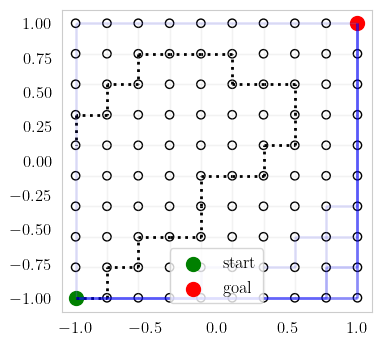

Acq optimizer x_next = (50, [40, 51, 60])
Finished iter i = 24
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.755250731891592
Found goal after visiting 100 vertices with estimated cost 2.985099917864768
Found goal after visiting 98 vertices with estimated cost 2.418654357346667
Found goal after visiting 96 vertices with estimated cost 2.509501669674629
Found goal after visiting 97 vertices with estimated cost 2.43067350214219
Found goal after visiting 98 vertices with estimated cost 2.229949824771235
Found goal after visiting 100 vertices with estimated cost 2.512215073609746
Found goal after visiting 100 vertices with estimated cost 2.6547578195869006
Found goal after visiting 86 vertices with estimated cost 1.984333253601602
Found goal after visiting 99 vertices with estimated cost 2.68629556846791
*[TIME] [Sample 10 execution paths] Ela

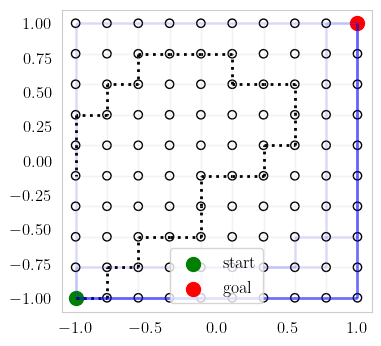

Acq optimizer x_next = (40, [30, 41, 50])
Finished iter i = 25
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 96 vertices with estimated cost 2.3481795589273204
Found goal after visiting 89 vertices with estimated cost 2.2601802867900327
Found goal after visiting 100 vertices with estimated cost 2.700311907450802
Found goal after visiting 80 vertices with estimated cost 2.0126014139089854
Found goal after visiting 100 vertices with estimated cost 2.5630751281710182
Found goal after visiting 82 vertices with estimated cost 2.0097212717665003
Found goal after visiting 82 vertices with estimated cost 1.9551970724021597
Found goal after visiting 79 vertices with estimated cost 1.9432224882256959
Found goal after visiting 87 vertices with estimated cost 2.0817160119538975
Found goal after visiting 100 vertices with estimated cost 2.7382239415765124
*[TIME] [Sample 10 execution p

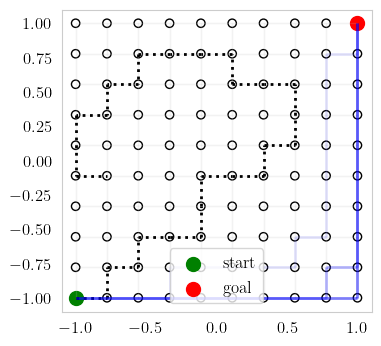

Acq optimizer x_next = (41, [31, 40, 42, 51])
Finished iter i = 26
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 98 vertices with estimated cost 2.244358003086508
Found goal after visiting 97 vertices with estimated cost 2.3486493006073714
Found goal after visiting 98 vertices with estimated cost 2.323137991520342
Found goal after visiting 94 vertices with estimated cost 2.3685029345084327
Found goal after visiting 99 vertices with estimated cost 2.5147758856658626
Found goal after visiting 95 vertices with estimated cost 2.354576487227736
Found goal after visiting 82 vertices with estimated cost 2.040596285686976
Found goal after visiting 85 vertices with estimated cost 2.114190002867369
Found goal after visiting 85 vertices with estimated cost 2.061424375540508
Found goal after visiting 98 vertices with estimated cost 2.315652506125933
*[TIME] [Sample 10 execution paths]

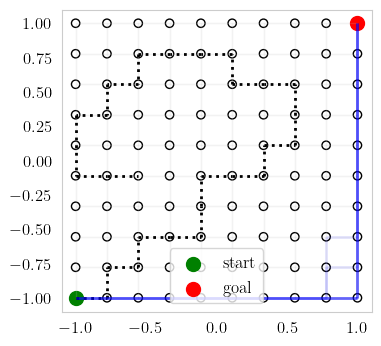

Acq optimizer x_next = (42, [32, 41, 43, 52])
Finished iter i = 27
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 93 vertices with estimated cost 2.2904305612167395
Found goal after visiting 88 vertices with estimated cost 2.0609666230325967
Found goal after visiting 79 vertices with estimated cost 1.9322342141646334
Found goal after visiting 78 vertices with estimated cost 1.9357312680490038
Found goal after visiting 88 vertices with estimated cost 2.1841128710519673
Found goal after visiting 100 vertices with estimated cost 2.825143927112503
Found goal after visiting 100 vertices with estimated cost 2.72734514654598
Found goal after visiting 97 vertices with estimated cost 2.427527540699124
Found goal after visiting 97 vertices with estimated cost 2.378307919655776
Found goal after visiting 77 vertices with estimated cost 1.9470677926537485
*[TIME] [Sample 10 execution pa

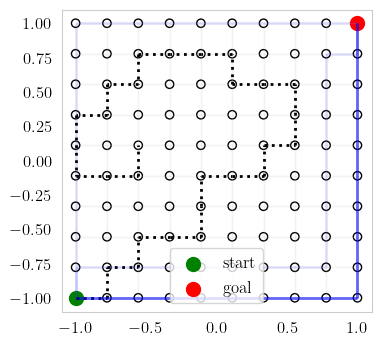

Acq optimizer x_next = (52, [42, 51, 53, 62])
Finished iter i = 28
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 2.261143278977517
Found goal after visiting 98 vertices with estimated cost 2.599894761614433
Found goal after visiting 100 vertices with estimated cost 2.5858881183878886
Found goal after visiting 93 vertices with estimated cost 2.3199854950700978
Found goal after visiting 98 vertices with estimated cost 2.375687747825973
Found goal after visiting 80 vertices with estimated cost 1.8988132571533805
Found goal after visiting 97 vertices with estimated cost 2.585000993597906
Found goal after visiting 100 vertices with estimated cost 2.714965948215422
Found goal after visiting 88 vertices with estimated cost 2.1878744909478662
Found goal after visiting 99 vertices with estimated cost 2.4540321411482595
*[TIME] [Sample 10 execution pa

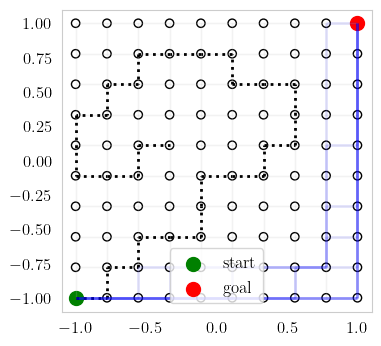

Acq optimizer x_next = (53, [43, 52, 54, 63])
Finished iter i = 29
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 80 vertices with estimated cost 1.9924830212249864
Found goal after visiting 89 vertices with estimated cost 2.3927269066217516
Found goal after visiting 71 vertices with estimated cost 1.8234034747148165
Found goal after visiting 93 vertices with estimated cost 2.4108828335018266
Found goal after visiting 86 vertices with estimated cost 2.146049543603579
Found goal after visiting 93 vertices with estimated cost 2.212361652429907
Found goal after visiting 80 vertices with estimated cost 1.9622415519839032
Found goal after visiting 99 vertices with estimated cost 2.2713040510385754
Found goal after visiting 73 vertices with estimated cost 1.8166941459398804
Found goal after visiting 91 vertices with estimated cost 2.3280996875425237
*[TIME] [Sample 10 execution p

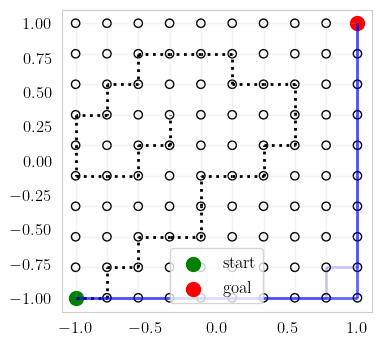

Acq optimizer x_next = (63, [53, 62, 64, 73])
Finished iter i = 30
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 92 vertices with estimated cost 2.224695668978918
Found goal after visiting 73 vertices with estimated cost 1.8113146406977751
Found goal after visiting 85 vertices with estimated cost 2.028269106724708
Found goal after visiting 86 vertices with estimated cost 2.217360973719357
Found goal after visiting 90 vertices with estimated cost 2.322285568664655
Found goal after visiting 97 vertices with estimated cost 2.4458425052627564
Found goal after visiting 100 vertices with estimated cost 2.7712357110595813
Found goal after visiting 95 vertices with estimated cost 2.575585226862547
Found goal after visiting 71 vertices with estimated cost 1.8537684125329366
Found goal after visiting 84 vertices with estimated cost 2.07272518713552
*[TIME] [Sample 10 execution paths

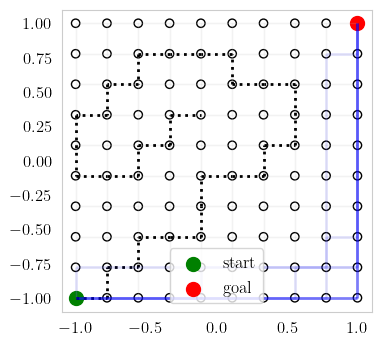

Acq optimizer x_next = (64, [54, 63, 65, 74])
Finished iter i = 31
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 89 vertices with estimated cost 2.139409943321063
Found goal after visiting 100 vertices with estimated cost 2.5106187537505367
Found goal after visiting 71 vertices with estimated cost 1.8058527801871167
Found goal after visiting 88 vertices with estimated cost 2.2787514079198865
Found goal after visiting 90 vertices with estimated cost 2.1774708137122145
Found goal after visiting 91 vertices with estimated cost 2.29756865406734
Found goal after visiting 91 vertices with estimated cost 2.153058284351215
Found goal after visiting 95 vertices with estimated cost 2.389139103910704
Found goal after visiting 80 vertices with estimated cost 1.988382272570598
Found goal after visiting 100 vertices with estimated cost 3.0840090790563055
*[TIME] [Sample 10 execution pat

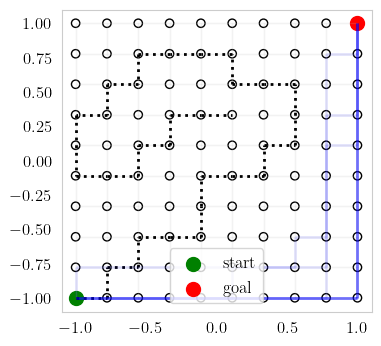

Acq optimizer x_next = (65, [55, 64, 66, 75])
Finished iter i = 32
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 93 vertices with estimated cost 2.401492602254165
Found goal after visiting 82 vertices with estimated cost 1.9902942614189598
Found goal after visiting 91 vertices with estimated cost 2.279699984937655
Found goal after visiting 99 vertices with estimated cost 2.6075801286077613
Found goal after visiting 98 vertices with estimated cost 2.4092562945646234
Found goal after visiting 65 vertices with estimated cost 1.7275676993739428
Found goal after visiting 76 vertices with estimated cost 1.9046709074073411
Found goal after visiting 84 vertices with estimated cost 2.0131279803059505
Found goal after visiting 97 vertices with estimated cost 2.7032764712985013
Found goal after visiting 84 vertices with estimated cost 2.050783307477456
*[TIME] [Sample 10 execution pa

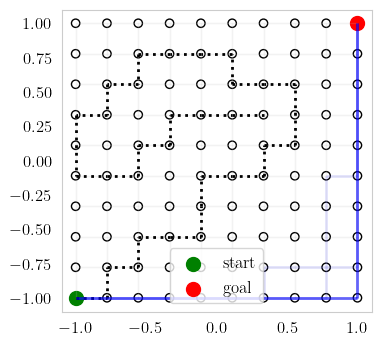

Acq optimizer x_next = (66, [56, 65, 67, 76])
Finished iter i = 33
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 85 vertices with estimated cost 2.0417153383958517
Found goal after visiting 78 vertices with estimated cost 2.0379427937121104
Found goal after visiting 94 vertices with estimated cost 2.3255694733168677
Found goal after visiting 100 vertices with estimated cost 2.4710872493911964
Found goal after visiting 86 vertices with estimated cost 2.1840299830014382
Found goal after visiting 90 vertices with estimated cost 2.1536890826407813
Found goal after visiting 92 vertices with estimated cost 2.3549273427705977
Found goal after visiting 88 vertices with estimated cost 2.229753849588815
Found goal after visiting 100 vertices with estimated cost 2.657067788650104
Found goal after visiting 80 vertices with estimated cost 1.8849928201362918
*[TIME] [Sample 10 execution

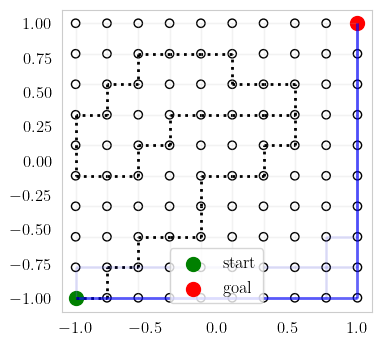

Acq optimizer x_next = (67, [57, 66, 68, 77])
Finished iter i = 34
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.730267285304485
Found goal after visiting 91 vertices with estimated cost 2.4433039786077693
Found goal after visiting 95 vertices with estimated cost 2.282606516939825
Found goal after visiting 99 vertices with estimated cost 2.5603038314654345
Found goal after visiting 100 vertices with estimated cost 3.093913893399133
Found goal after visiting 92 vertices with estimated cost 2.2920210641139382
Found goal after visiting 87 vertices with estimated cost 2.155698318579992
Found goal after visiting 99 vertices with estimated cost 2.565167932367422
Found goal after visiting 87 vertices with estimated cost 2.139527020439841
Found goal after visiting 95 vertices with estimated cost 2.48875298895042
*[TIME] [Sample 10 execution paths

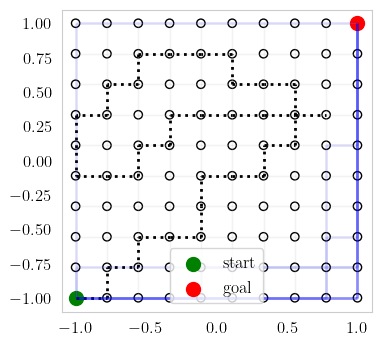

Acq optimizer x_next = (68, [58, 67, 69, 78])
Finished iter i = 35
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 91 vertices with estimated cost 2.2329533289706696
Found goal after visiting 80 vertices with estimated cost 1.9524672363901778
Found goal after visiting 82 vertices with estimated cost 1.95562028647265
Found goal after visiting 93 vertices with estimated cost 2.5578164310483293
Found goal after visiting 84 vertices with estimated cost 2.017645907695659
Found goal after visiting 92 vertices with estimated cost 2.2623501589799435
Found goal after visiting 89 vertices with estimated cost 2.331803499630611
Found goal after visiting 94 vertices with estimated cost 2.4369910286218825
Found goal after visiting 98 vertices with estimated cost 2.450558311104648
Found goal after visiting 83 vertices with estimated cost 2.1225286747888132
*[TIME] [Sample 10 execution path

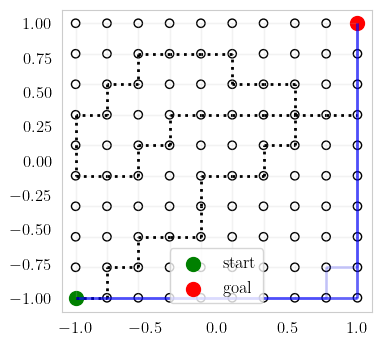

Acq optimizer x_next = (69, [59, 68, 79])
Finished iter i = 36
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.8544782746117017
Found goal after visiting 83 vertices with estimated cost 1.9378297729251108
Found goal after visiting 89 vertices with estimated cost 2.2170358703353656
Found goal after visiting 77 vertices with estimated cost 1.9167777562630695
Found goal after visiting 62 vertices with estimated cost 1.769036564136325
Found goal after visiting 99 vertices with estimated cost 2.592701932352612
Found goal after visiting 98 vertices with estimated cost 2.683224152332164
Found goal after visiting 100 vertices with estimated cost 3.2509252389108534
Found goal after visiting 100 vertices with estimated cost 2.841549175859006
Found goal after visiting 81 vertices with estimated cost 1.9912354167390756
*[TIME] [Sample 10 execution path

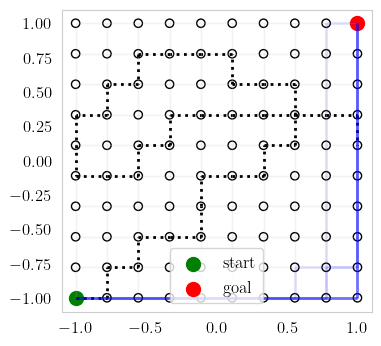

Acq optimizer x_next = (59, [49, 58, 69])
Finished iter i = 37
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 60 vertices with estimated cost 1.6633974219817267
Found goal after visiting 98 vertices with estimated cost 2.503437757818813
Found goal after visiting 82 vertices with estimated cost 2.033431550011595
Found goal after visiting 82 vertices with estimated cost 1.9528089333068548
Found goal after visiting 85 vertices with estimated cost 2.138618090277296
Found goal after visiting 75 vertices with estimated cost 1.8450564493415373
Found goal after visiting 97 vertices with estimated cost 2.4714596506208064
Found goal after visiting 92 vertices with estimated cost 2.244610357408924
Found goal after visiting 93 vertices with estimated cost 2.170704213630538
Found goal after visiting 98 vertices with estimated cost 2.920018207654107
*[TIME] [Sample 10 execution paths] El

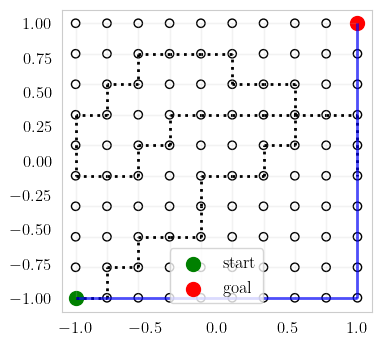

Acq optimizer x_next = (49, [39, 48, 59])
Finished iter i = 38
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.148566626326735
Found goal after visiting 100 vertices with estimated cost 2.8919800826701167
Found goal after visiting 98 vertices with estimated cost 2.5264441350052778
Found goal after visiting 97 vertices with estimated cost 2.630309275758428
Found goal after visiting 88 vertices with estimated cost 2.185768742783731
Found goal after visiting 98 vertices with estimated cost 2.839742727625715
Found goal after visiting 88 vertices with estimated cost 2.1645357232679956
Found goal after visiting 93 vertices with estimated cost 2.3522545345120838
Found goal after visiting 97 vertices with estimated cost 2.442982624010777
Found goal after visiting 98 vertices with estimated cost 2.671356357679776
*[TIME] [Sample 10 execution paths] 

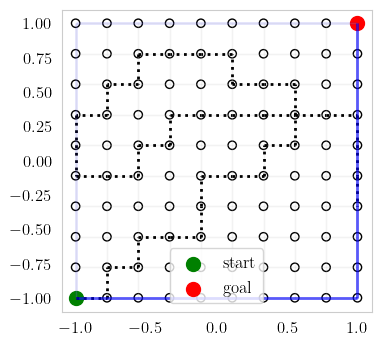

Acq optimizer x_next = (39, [29, 38, 49])
Finished iter i = 39


In [13]:
# BAX iterations
import time

n_iter = 40

for i in range(n_iter):
    # Optimize acquisition function
    acqopt = AcqOptimizer({'n_path': 10,
                           'viz_acq': False})
    arg_x_next = acqopt.optimize(model, algo, x_test, return_argmax=True)

    # Query function, update data
    x_next = x_test[arg_x_next]
    y_next = f(x_next)
    data.x.append(x_next)
    data.y.append(y_next)
    
    # Update physical path taken
    next_vertex = current_path[-1].neighbors[arg_x_next]
    current_path.append(next_vertex)
    #print(f"Incurred true cost so far: {cost_of_path(current_path, cost_func)}")
    
    # Update next set of x_test    
    x_test = possible_steps(next_vertex)

    # Update model
    model = SimpleGp(gp_params)
    model.set_data(data)
    
    fig, ax = plot_progress(edges, start, goal, current_path[:-1])
    
    last_outputs = acqopt.get_last_output_list()
    min_costs, min_cost_paths = zip(*last_outputs)
    n = acqopt.params.n_path
    for path in min_cost_paths:
        plot_path(ax, path, path_color=(0, 0, 1, 1/n), linewidths=2, linestyle="-")
    
    # make matplotlib plot within for loop. See: https://stackoverflow.com/questions/19766100/real-time-matplotlib-plot-is-not-working-while-still-in-a-loop
    plt.pause(0.0001)
    
    print(f'Acq optimizer x_next = {next_vertex}')
    print(f'Finished iter i = {i}')